In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.models import load_model
from keras.applications import DenseNet169
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

import os
import shutil

import cv2

img_list and labels for pulmonary-chest-xray-abnormalities dataset

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# 1️⃣ Install the tools
!pip install --quiet kaggle opendatasets

In [3]:
# 2️⃣ Upload your kaggle.json credentials
#    - In Colab’s left‑sidebar click “Files” → “Upload” → select your ~/.kaggle/kaggle.json
#    - (This file you can download from your Kaggle account settings → API)
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3️⃣ Use opendatasets to fetch the data
import opendatasets as od

# Replace with your dataset slug (username/dataset-name)
dataset_slug = "vbookshelf/tbx11k-simplified"
od.download(f"https://www.kaggle.com/{dataset_slug}")

# 4️⃣ Unzip (if needed) and inspect
import os
data_dir = os.path.join(os.getcwd(), dataset_slug.split("/")[-1])
print("Files in dataset:", os.listdir(data_dir))

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: youngdee
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/vbookshelf/tbx11k-simplified


100%|██████████| 2.95G/2.95G [00:25<00:00, 123MB/s] 

Files in dataset: ['tbx11k-simplified']


creating img_list and labels for tuberculosis-tb-chest-xray-dataset

In [2]:
df = pd.read_csv('tbx11k-simplified/tbx11k-simplified/data.csv')
df.head()

,fname,image_height,image_width,source,bbox,target,tb_type,image_type
0,h0001.png,512,512,train,none,no_tb,none,healthy
1,h0003.png,512,512,train,none,no_tb,none,healthy
2,h0005.png,512,512,train,none,no_tb,none,healthy
3,h0008.png,512,512,train,none,no_tb,none,healthy
4,h0009.png,512,512,train,none,no_tb,none,healthy


In [3]:
df['tb_type'].value_counts()

,count
tb_type,
none,7600
active_tb,972
latent_tb,239


In [4]:
df['image_type'].value_counts()

,count
image_type,
healthy,3800
sick_but_no_tb,3800
tb,1211


In [5]:
df['bbox'].value_counts()

,count
bbox,
none,7600
"{'xmin': 74.32405853271484, 'ymin': 38.69781494140625, 'width': 130.03579711914062, 'height': 99.24453735351562}",1
"{'xmin': 245.07554626464844, 'ymin': 41.49701690673828, 'width': 108.15110778808594, 'height': 75.83300018310547}",1
"{'xmin': 77.54379272460938, 'ymin': 125.16328430175781, 'width': 127.19404602050781, 'height': 83.34883117675781}",1
"{'xmin': 311.0129699707031, 'ymin': 121.30267333984375, 'width': 141.89950561523438, 'height': 166.615234375}",1
...,...
"{'xmin': 304.8858642578125, 'ymin': 75.97962188720703, 'width': 87.4947509765625, 'height': 107.08719635009766}",1
"{'xmin': 123.49848175048828, 'ymin': 99.24456787109375, 'width': 66.91793060302734, 'height': 65.68928527832031}",1
"{'xmin': 287.95892333984375, 'ymin': 39.31131362915039, 'width': 176.4439697265625, 'height': 185.10769653320312}",1


In [6]:
df['target'].value_counts()

,count
target,
no_tb,7600
tb,1211


In [7]:
import os
import cv2
import pandas as pd
import numpy as np

# ── 1. Paths ───────────────────────────────────────────────────────────────────
BASE_DIR = "tbx11k-simplified/tbx11k-simplified"
IMG_DIR  = os.path.join(BASE_DIR, "images")
CSV_PATH = os.path.join(BASE_DIR, "data.csv")

# ── 2. Load metadata ─────────────────────────────────────────────────────────
df = pd.read_csv(CSV_PATH)
print("Total records:", len(df))
print("Target distribution:\n", df["target"].value_counts(), "\n")

# ── 3. Filter by string labels ────────────────────────────────────────────────
# 'no_tb' → Normal  (we’ll call label 0)
# 'tb'    → Tuberculosis (label 1)
normals = df[df["target"] == "no_tb"]
tbs     = df[df["target"] == "tb"]

print(f"Available normals: {len(normals)}, TBs: {len(tbs)}")

# ── 4. Sample up to 700 normals ───────────────────────────────────────────────
n_sample = min(700, len(normals))
normal_df = normals.sample(n=n_sample, random_state=42)
tb_df     = tbs  # use all TB images

print(f"Using {len(normal_df)} normals and {len(tb_df)} TBs for a total of {len(normal_df)+len(tb_df)} images.\n")

# ── 5. Load, resize & normalize ───────────────────────────────────────────────
img_list, labels = [], []

def load_and_prep(fname, label):
    path = os.path.join(IMG_DIR, fname)
    img  = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Couldn't load image at {path}")
    img  = cv2.resize(img, (256, 256)) / 255.0
    img_list.append(img)
    labels.append(label)

# Normal = 0
for fname in normal_df["fname"]:
    load_and_prep(fname, 0)

# TB = 1
for fname in tb_df["fname"]:
    load_and_prep(fname, 1)

# ── 6. Convert to arrays & shuffle ────────────────────────────────────────────
X = np.stack(img_list, axis=0)
y = np.array(labels)

# Shuffle in unison
perm = np.random.RandomState(42).permutation(len(X))
X, y = X[perm], y[perm]

print("Done loading!")
print("X.shape:", X.shape)  # (n_samples, 256, 256, 3)
print("y.shape:", y.shape)  # (n_samples,)


Total records: 8811
Target distribution:
 target
no_tb    7600
tb       1211
Name: count, dtype: int64 

Available normals: 7600, TBs: 1211
Using 700 normals and 1211 TBs for a total of 1911 images.

Done loading!
X.shape: (1911, 256, 256, 3)
y.shape: (1911,)


creating img_list and labels for tbx11k-simplified dataset

In [8]:
import os
import random
import cv2
import pandas as pd
import numpy as np

# ── 1. Paths ───────────────────────────────────────────────────────────────────
BASE_DIR = "/content/tbx11k-simplified/tbx11k-simplified"
IMG_DIR  = os.path.join(BASE_DIR, "images")
CSV_PATH = os.path.join(BASE_DIR, "data.csv")

# ── 2. Load metadata ─────────────────────────────────────────────────────────
data_df = pd.read_csv(CSV_PATH)

# ── 3. Gather filenames ───────────────────────────────────────────────────────
active_tb = data_df.loc[data_df["tb_type"] == "active_tb", "fname"].unique().tolist()
normal    = data_df.loc[data_df["image_type"] == "healthy",   "fname"].tolist()

# ── 4. Sample normals to match TB count ────────────────────────────────────────
n_tb           = len(active_tb)
selected_normal = random.sample(normal, n_tb)

print(f"Number of active TB images: {n_tb}")
print(f"Number of sampled healthy images: {len(selected_normal)}")

# ── 5. Load, resize, normalize & label ────────────────────────────────────────
imgs, labels = [], []

def load_and_prep(fname, label):
    path = os.path.join(IMG_DIR, fname)
    img  = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    img  = cv2.resize(img, (256, 256)) / 255.0
    imgs.append(img)
    labels.append(label)

# Healthy = 0
for fname in selected_normal:
    load_and_prep(fname, 0)

# Active TB = 1
for fname in active_tb:
    load_and_prep(fname, 1)

# ── 6. Convert to NumPy arrays & shuffle ──────────────────────────────────────
X = np.stack(imgs, axis=0)
y = np.array(labels)

# Shuffle
perm = np.random.RandomState(42).permutation(len(X))
X, y = X[perm], y[perm]

print("Done!")
print("X.shape:", X.shape)  # (2 * n_tb, 256, 256, 3)
print("y.shape:", y.shape)  # (2 * n_tb,)

Number of active TB images: 660
Number of sampled healthy images: 660
Done!
X.shape: (1320, 256, 256, 3)
y.shape: (1320,)


In [9]:
from sklearn.model_selection import train_test_split

# Use your NumPy arrays X, y (shape (1320, ...))
print("X.shape:", X.shape)
print("y.shape:", y.shape)

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=y        # keeps class balance in splits
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Val   shapes:", X_val.shape,   y_val.shape)


X.shape: (1320, 256, 256, 3)
y.shape: (1320,)
Train shapes: (1056, 256, 256, 3) (1056,)
Val   shapes: (264, 256, 256, 3) (264,)


In [10]:
# assuming you have X_val and y_val already
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val,
    test_size=0.20,
    random_state=42,
    shuffle=True,
    stratify=y_val
)

In [11]:
print("Val shapes:", X_val.shape, y_val.shape)
print("Test   shapes:", X_test.shape,   y_test.shape)

Val shapes: (211, 256, 256, 3) (211,)
Test   shapes: (53, 256, 256, 3) (53,)


In [12]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# ── 1) Paths & hyperparams ─────────────────────────────────────────────────
ROOT_DIR    = os.path.join(os.getcwd(), 'tbx11k-simplified', 'tbx11k-simplified')
CSV_PATH    = os.path.join(ROOT_DIR, 'data.csv')
IMG_DIR     = os.path.join(ROOT_DIR, 'images')

# Try 64×64 batch=4 if you still OOM
IMG_SIZE    = (128, 128)
BATCH_SIZE  = 8
NUM_CLASSES = 2
EPOCHS      = 15

# ── 2) Custom metrics ───────────────────────────────────────────────────────
def jaccard_index(y_true, y_pred, smooth=100):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    inter   = tf.reduce_sum(y_true_f * y_pred_f)
    total   = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - inter
    return (inter + smooth) / (total + smooth)

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    inter   = tf.reduce_sum(y_true_f * y_pred_f)
    return (2*inter + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# ── 3) Load & split CSV ──────────────────────────────────────────────────────
df = pd.read_csv(CSV_PATH)
df = df[df['target'].isin(['no_tb','tb'])].copy()
df['label'] = df['target'].map({'no_tb':0, 'tb':1})

tr, te = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
tr, va = train_test_split(tr, test_size=0.2, stratify=tr['label'], random_state=42)

# ── 4) Build minimal tf.data pipelines ──────────────────────────────────────
def make_ds(df, shuffle=False):
    paths  = df['fname'].apply(lambda x: os.path.join(IMG_DIR, x)).values
    labels = df['label'].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    def _parse(path, lbl):
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE) / 255.0
        return img, tf.one_hot(lbl, NUM_CLASSES)
    ds = ds.map(_parse, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(100)           # only buffer 100 images
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(1)               # only prefetch 1 batch
    return ds

train_ds = make_ds(tr, shuffle=True)
val_ds   = make_ds(va, shuffle=False)
test_ds  = make_ds(te, shuffle=False)

# ── 5) Small CNN ─────────────────────────────────────────────────────────────
model = models.Sequential([
    layers.Input((*IMG_SIZE,3)),
    layers.Conv2D(32,3,activation='relu',padding='same'), layers.MaxPooling2D(),
    layers.Conv2D(64,3,activation='relu',padding='same'), layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES,activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', jaccard_index, dice_coefficient]
)

# ── 6) Kick off training ────────────────────────────────────────────────────
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# ── 7) Evaluate & save ───────────────────────────────────────────────────────
print(model.evaluate(test_ds))
model.save('tbx11k_streaming_model.h5')


Epoch 1/15
705/705 ━━━━━━━━━━━━━━━━━━━━ 54s 64ms/step - accuracy: 0.8855 - dice_coefficient: 0.8262 - jaccard_index: 0.9731 - loss: 0.3913 - val_accuracy: 0.9567 - val_dice_coefficient: 0.9340 - val_jaccard_index: 0.9897 - val_loss: 0.1401
Epoch 2/15
705/705 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/step - accuracy: 0.9444 - dice_coefficient: 0.9158 - jaccard_index: 0.9869 - loss: 0.1615 - val_accuracy: 0.9688 - val_dice_coefficient: 0.9132 - val_jaccard_index: 0.9865 - val_loss: 0.1284
Epoch 3/15
705/705 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - accuracy: 0.9593 - dice_coefficient: 0.9352 - jaccard_index: 0.9899 - loss: 0.1244 - val_accuracy: 0.9709 - val_dice_coefficient: 0.9195 - val_jaccard_index: 0.9874 - val_loss: 0.1222
Epoch 4/15
705/705 ━━━━━━━━━━━━━━━━━━━━ 45s 63ms/step - accuracy: 0.9698 - dice_coefficient: 0.9521 - jaccard_index: 0.9925 - loss: 0.0875 - val_accuracy: 0.9809 - val_dice_coefficient: 0.9602 - val_jaccard_index: 0.9938 - val_loss: 0.0791
Epoch 5/15
705/705 ━━━━━━━━━━━━━━━━━━━━ 

[0.09210857003927231, 0.9875212907791138, 0.9979841113090515, 0.9870865941047668]


In [14]:
from tqdm import tqdm
import cv2
import numpy as np

# ── 1. Define simple preprocess fn ──────────────────────────────────────────
def preprocess(img, size=(256, 256)):
    img_resized = cv2.resize(img, size)
    return img_resized.astype(np.float32) / 255.0

# ── 2. Apply to your splits ─────────────────────────────────────────────────
X_train_preprocessed = np.stack([
    preprocess(img, IMG_SIZE)
    for img in tqdm(X_train, desc="Processing Training Data")
])

X_val_preprocessed = np.stack([
    preprocess(img, IMG_SIZE)
    for img in tqdm(X_val, desc="Processing Validation Data")
])

X_test_preprocessed = np.stack([
    preprocess(img, IMG_SIZE)
    for img in tqdm(X_test, desc="Processing Test Data")
])

# ── 3. (Optional) Other arrays ───────────────────────────────────────────────
# If you do have another set, e.g. img_test_2, make sure it's defined first:
# if 'img_test_2' in locals():
#     img_test_2_preprocessed = np.stack([
#         preprocess(img, IMG_SIZE)
#         for img in tqdm(img_test_2, desc="Processing img_test_2")
#     ])


Processing Test Data: 100%|██████████| 53/53 [00:00<00:00, 3822.58it/s]


In [15]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Base paths
ROOT_DIR = os.path.join(os.getcwd(), 'tbx11k-simplified', 'tbx11k-simplified')
IMG_DIR  = os.path.join(ROOT_DIR, 'images')
CSV_PATH = os.path.join(ROOT_DIR, 'data.csv')

# Load & filter
df = pd.read_csv(CSV_PATH)
df = df[df['target'].isin(['no_tb', 'tb'])].copy()
df['label'] = df['target'].map({'no_tb':'healthy', 'tb':'disease'})  # or keep 'no_tb','tb'

# Build full filepath column
df['filepath'] = df['fname'].apply(lambda f: os.path.join(IMG_DIR, f))

# Stratified split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df  = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)


Testing our ImageDataGenerator

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 8    # smaller is safer on RAM/GPU
img_size   = (128, 128)  # lower res for less memory

# Augmenting generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.05,
    horizontal_flip=True,
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Build generators
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)


Found 5638 validated image filenames belonging to 2 classes.
Found 1410 validated image filenames belonging to 2 classes.


In [17]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    steps_per_epoch=len(train_gen),   # = ceil(num_train / batch_size)
    validation_steps=len(val_gen),
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
705/705 ━━━━━━━━━━━━━━━━━━━━ 99s 141ms/step - accuracy: 0.8265 - dice_coefficient: 0.7369 - jaccard_index: 0.9597 - loss: 0.8737 - val_accuracy: 0.8773 - val_dice_coefficient: 0.8362 - val_jaccard_index: 0.9746 - val_loss: 0.3260
Epoch 2/20
705/705 ━━━━━━━━━━━━━━━━━━━━ 141s 139ms/step - accuracy: 0.9142 - dice_coefficient: 0.8609 - jaccard_index: 0.9784 - loss: 0.2529 - val_accuracy: 0.9262 - val_dice_coefficient: 0.8851 - val_jaccard_index: 0.9822 - val_loss: 0.2302
Epoch 3/20
705/705 ━━━━━━━━━━━━━━━━━━━━ 141s 139ms/step - accuracy: 0.9144 - dice_coefficient: 0.8721 - jaccard_index: 0.9802 - loss: 0.2419 - val_accuracy: 0.9248 - val_dice_coefficient: 0.8873 - val_jaccard_index: 0.9825 - val_loss: 0.2166
Epoch 4/20
705/705 ━━━━━━━━━━━━━━━━━━━━ 142s 139ms/step - accuracy: 0.9295 - dice_coefficient: 0.8967 - jaccard_index: 0.9839 - loss: 0.1988 - val_accuracy: 0.9270 - val_dice_coefficient: 0.9080 - val_jaccard_index: 0.9857 - val_loss: 0.2126
Epoch 5/20
705/705 ━━━━━━━━━━━━━━

Training Data Batch:


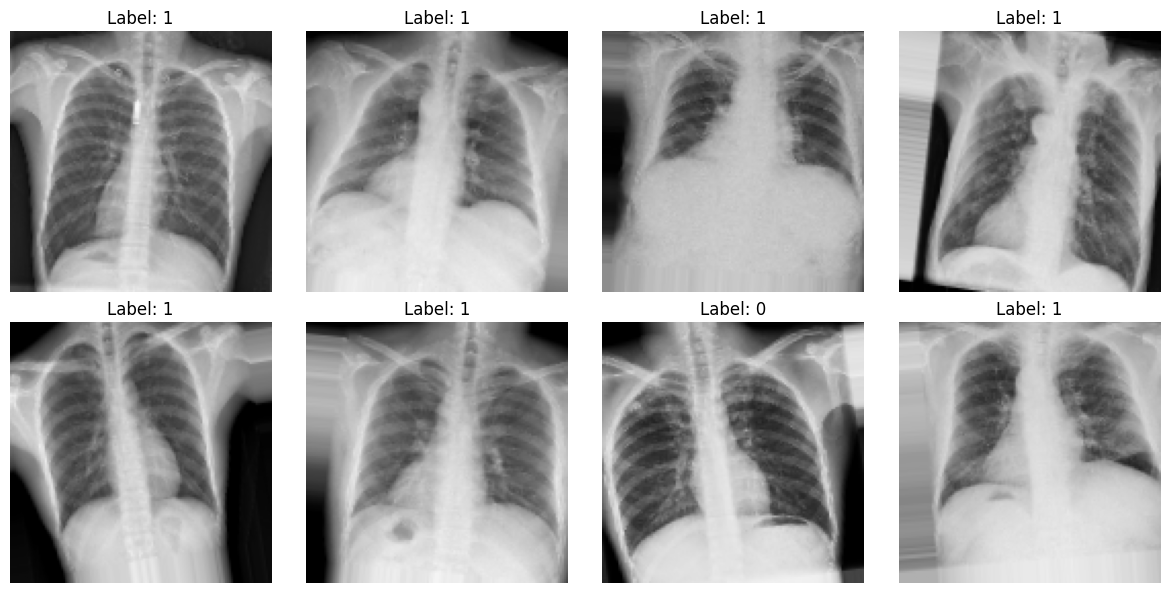

Validation Data Batch:


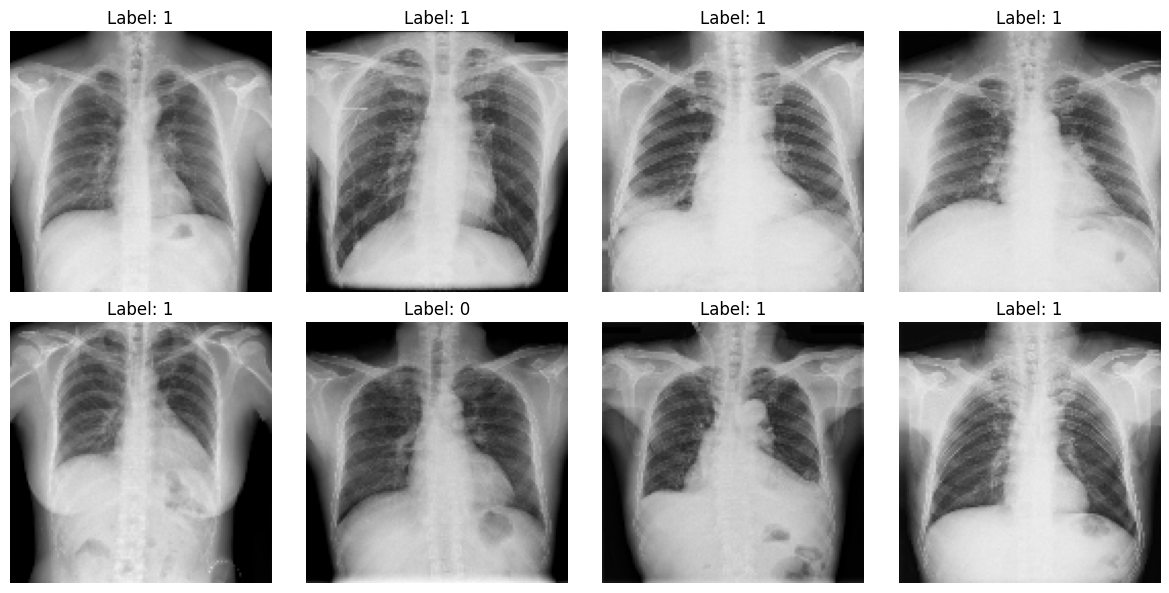

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def show_batch_from_generator(gen, n_images=8):
    # Grab one batch
    images, labels = next(gen)
    # If labels are one‑hot, convert to class indices
    if labels.ndim == 2:
        labels = np.argmax(labels, axis=1)

    plt.figure(figsize=(12, 6))
    for i in range(min(n_images, len(images))):
        ax = plt.subplot(2, 4, i + 1)
        img = images[i]
        # If pixel values are [0,1], just show
        ax.imshow(img)
        ax.set_title(f"Label: {labels[i]}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

print("Training Data Batch:")
show_batch_from_generator(train_gen)

print("Validation Data Batch:")
show_batch_from_generator(val_gen)


In [19]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split

# ── 1) Paths & Constants ─────────────────────────────────────────────────────
# (Adjust this to wherever you have “tbx11k-simplified/tbx11k-simplified” in Colab)
ROOT_DIR = os.path.join(os.getcwd(), "tbx11k-simplified", "tbx11k-simplified")
CSV_PATH = os.path.join(ROOT_DIR, "data.csv")
IMG_DIR  = os.path.join(ROOT_DIR, "images")

# We want 256×256 inputs to match DenseNet169’s input_shape
IMG_SIZE    = (256, 256)
BATCH_SIZE  = 8    # keep small to avoid OOM
NUM_CLASSES = 2    # “no_tb” vs “tb”
EPOCHS      = 15

# ── 2) Load CSV & split ───────────────────────────────────────────────────────
df = pd.read_csv(CSV_PATH)

# Filter to only “no_tb” and “tb”
df = df[df["target"].isin(["no_tb", "tb"])].copy()
# Map labels to strings or ints—flow_from_dataframe wants string labels by default
df["label"] = df["target"].map({"no_tb": "no_tb", "tb": "tb"})

# Full file path needed for flow_from_dataframe
df["filepath"] = df["fname"].apply(lambda f: os.path.join(IMG_DIR, f))

# Stratified train/val/test split (64%/16%/20%)
train_df, test_df = train_test_split(
    df, test_size=0.20, stratify=df["label"], random_state=42
)
train_df, val_df  = train_test_split(
    train_df, test_size=0.20, stratify=train_df["label"], random_state=42
)

print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}, Test samples: {len(test_df)}")

# ── 3) Build ImageDataGenerators ─────────────────────────────────────────────
# NOTE: We rescale all images to [0,1] and apply augmentations on the fly.
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.05,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# train generator: 256×256, batch_size=8, shuffle=True
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="binary",      # since we have 2 classes (“no_tb” vs “tb”)
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# validation generator: 256×256, batch_size=8, shuffle=False
val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# test generator (used later for evaluation)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# ── 4) Build & compile the DenseNet169‑based model ──────────────────────────
strategy = tf.distribute.MirroredStrategy()
print("Number of GPUs detected:", strategy.num_replicas_in_sync)

with strategy.scope():
    # Load DenseNet169 pre‑trained on ImageNet, freeze most of it
    densenet_base = DenseNet169(
        weights="imagenet",
        include_top=False,
        input_shape=(*IMG_SIZE, 3),
    )
    densenet_base.trainable = False
    # Un‑freeze the last 10 layers (fine‑tuning)
    for layer in densenet_base.layers[-10:]:
        layer.trainable = True

    # Build the classification head
    inp = Input(shape=(*IMG_SIZE, 3))
    x = densenet_base(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Dense(8, activation="relu")(x)
    x = BatchNormalization()(x)
    out = Dense(1, activation="sigmoid")(x)

    classification_model = Model(inputs=inp, outputs=out)
    classification_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="binary_crossentropy",
        metrics=["accuracy", Precision(name="precision"), Recall(name="recall")],
    )

classification_model.summary()

# ── 5) Train using generators ────────────────────────────────────────────────
# Calculate how many steps per epoch and validation steps
steps_per_epoch = train_gen.samples // BATCH_SIZE
val_steps       = val_gen.samples // BATCH_SIZE

history = classification_model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=EPOCHS,
)

# ── 6) Evaluate on the test set ──────────────────────────────────────────────
test_steps = test_gen.samples // BATCH_SIZE
results = classification_model.evaluate(test_gen, steps=test_steps)
print("Test loss, accuracy, precision, recall:", results)

# ── 7) Save final model ─────────────────────────────────────────────────────
classification_model.save("tbx11k_densenet169_finetuned.h5")


Train samples: 5638, Val samples: 1410, Test samples: 1763
Found 5638 validated image filenames belonging to 2 classes.
Found 1410 validated image filenames belonging to 2 classes.
Found 1763 validated image filenames belonging to 2 classes.
Number of GPUs detected: 1
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 8, 8, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1664)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       106,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,752,209 (48.65 MB)

 Trainable params: 361,729 (1.38 MB)

 Non-trainable params: 12,390,480 (47.27 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 207s 266ms/step - accuracy: 0.6972 - loss: 0.5786 - precision: 0.2436 - recall: 0.5206 - val_accuracy: 0.9339 - val_loss: 0.2200 - val_precision: 0.7012 - val_recall: 0.9072
Epoch 2/15
  1/704 ━━━━━━━━━━━━━━━━━━━━ 1:19 113ms/step - accuracy: 1.0000 - loss: 0.2200 - precision: 0.0000e+00 - recall: 0.0000e+00

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


704/704 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 1.0000 - loss: 0.2200 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9297 - val_loss: 0.2264 - val_precision: 0.6834 - val_recall: 0.9124
Epoch 3/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 229s 257ms/step - accuracy: 0.9047 - loss: 0.2423 - precision: 0.6750 - recall: 0.6143 - val_accuracy: 0.9673 - val_loss: 0.1078 - val_precision: 0.9302 - val_recall: 0.8247
Epoch 4/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8750 - loss: 0.1864 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9673 - val_loss: 0.1058 - val_precision: 0.9253 - val_recall: 0.8299
Epoch 5/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 202s 286ms/step - accuracy: 0.9207 - loss: 0.2025 - precision: 0.7330 - recall: 0.6179 - val_accuracy: 0.9695 - val_loss: 0.1112 - val_precision: 0.8872 - val_recall: 0.8918
Epoch 6/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 1.0000 - loss: 0.0708 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.

Test loss, accuracy, precision, recall: [0.315935343503952, 0.8772727251052856, 0.5266666412353516, 0.987500011920929]


Plotting accuracy and loss graph

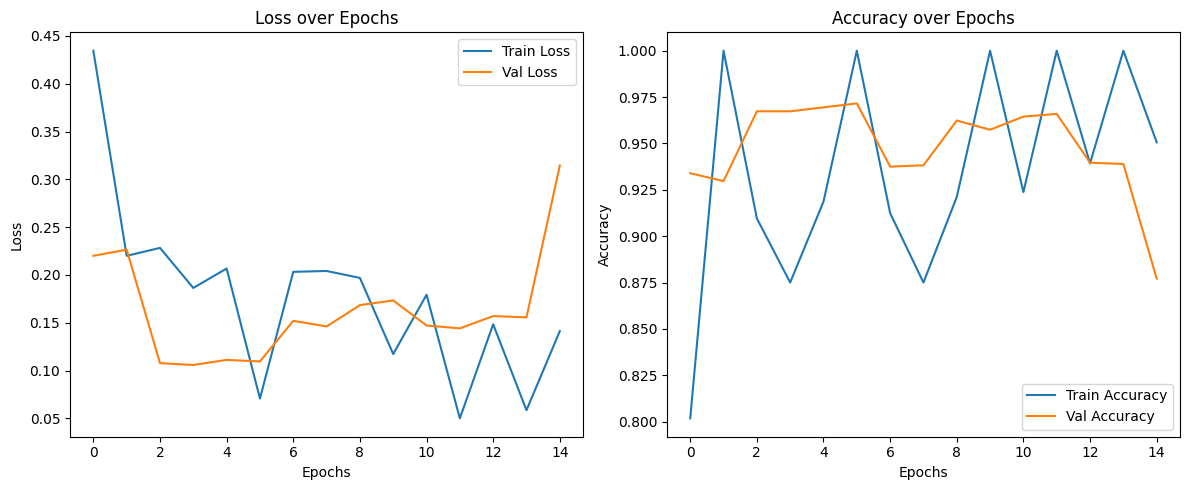

In [20]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy Plot (if your model has accuracy metric)
if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

plt.tight_layout()
plt.savefig("training_plot.png", dpi=300, bbox_inches='tight')
plt.show()


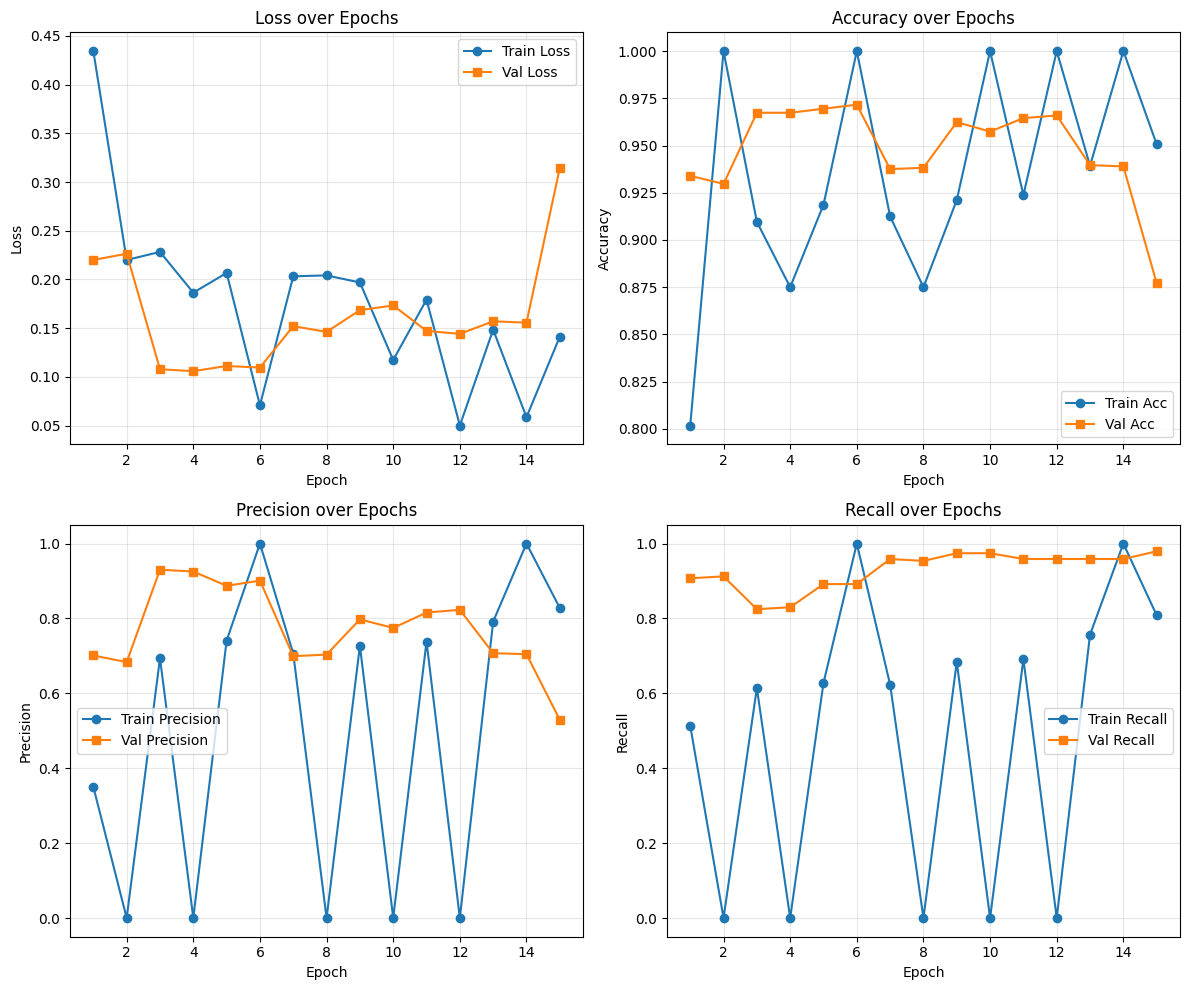

In [21]:
import matplotlib.pyplot as plt

# Make sure `history` is the returned object from model.fit(...)
# e.g. history = classification_model.fit(...)

# Number of epochs (for x‑axis)
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12, 10))

# ── 1. Loss ──────────────────────────────────────────────────────────────────
plt.subplot(2, 2, 1)
plt.plot(epochs, history.history['loss'], marker='o', label='Train Loss')
plt.plot(epochs, history.history['val_loss'], marker='s', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(alpha=0.3)

# ── 2. Accuracy ─────────────────────────────────────────────────────────────
if 'accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.history['accuracy'], marker='o', label='Train Acc')
    plt.plot(epochs, history.history['val_accuracy'], marker='s', label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(alpha=0.3)

# ── 3. Precision ────────────────────────────────────────────────────────────
if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history.history['precision'], marker='o', label='Train Precision')
    plt.plot(epochs, history.history['val_precision'], marker='s', label='Val Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title('Precision over Epochs')
    plt.legend()
    plt.grid(alpha=0.3)

# ── 4. Recall ───────────────────────────────────────────────────────────────
if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history.history['recall'], marker='o', label='Train Recall')
    plt.plot(epochs, history.history['val_recall'], marker='s', label='Val Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Recall over Epochs')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("training_metrics_plot.png", dpi=300, bbox_inches='tight')
plt.show()


221/221 ━━━━━━━━━━━━━━━━━━━━ 36s 143ms/step
Classification Report:
              precision    recall  f1-score   support

       no_tb       1.00      0.86      0.92      1521
          tb       0.53      0.99      0.69       242

    accuracy                           0.88      1763
   macro avg       0.76      0.92      0.81      1763
weighted avg       0.93      0.88      0.89      1763



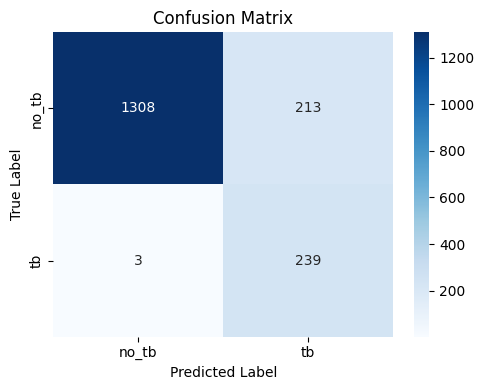

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ── 1. Get true labels from the generator ─────────────────────────────────────
# Make sure test_gen was created with shuffle=False in flow_from_dataframe
y_true = test_gen.classes  # an array of 0/1 labels for “no_tb” vs “tb”
num_test = len(y_true)

# ── 2. Predict on the entire test set ─────────────────────────────────────────
# Compute how many steps are needed to yield all test samples
steps = int(np.ceil(num_test / batch_size))

# `predict` will return an array of shape (num_samples, 1) since class_mode="binary"
y_pred_probs = classification_model.predict(test_gen, steps=steps, verbose=1)
y_pred_probs = y_pred_probs.ravel()[:num_test]  # flatten and trim any extra

# Convert probabilities → binary labels (0 or 1) using 0.5 threshold
y_pred = (y_pred_probs > 0.5).astype(int)

# ── 3. Compute confusion matrix & classification report ────────────────────────
cm = confusion_matrix(y_true, y_pred)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

# ── 4. Plot confusion matrix heatmap ──────────────────────────────────────────
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(test_gen.class_indices.keys()),
    yticklabels=list(test_gen.class_indices.keys())
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

In [27]:
import os
import zipfile
import shutil
from google.colab import files

# ── 1) Save model in all supported formats ──────────────────────────────

# a. Keras 3 recommended format
classification_model.save("tbx11k_classifier.keras")

# b. Legacy HDF5 format
classification_model.save("tbx11k_classifier.h5")

# c. TensorFlow SavedModel format via export (Keras 3 compliant)
saved_model_dir = "tbx11k_saved_model"
if os.path.exists(saved_model_dir):
    shutil.rmtree(saved_model_dir)
classification_model.export(saved_model_dir)  # Correct Keras 3 API

# ── 2) Zip all model files ──────────────────────────────────────────────

zip_filename = "tbx11k_models_package.zip"
with zipfile.ZipFile(zip_filename, "w", zipfile.ZIP_DEFLATED) as zipf:
    zipf.write("tbx11k_classifier.h5")
    zipf.write("tbx11k_classifier.keras")
    for root, _, files_in_dir in os.walk(saved_model_dir):
        for file in files_in_dir:
            filepath = os.path.join(root, file)
            arcname = os.path.relpath(filepath, ".")
            zipf.write(filepath, arcname)

# ── 3) Download the ZIP ─────────────────────────────────────────────────

files.download(zip_filename)


Saved artifact at 'tbx11k_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_604')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133767832763856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133767832764048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133767832764240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133767832760208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133767832763664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133767832761360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133768612035280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133767832763280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133767832761744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133768612034896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13376861

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>